## Классификация текстов

В данном задании работаем над задачей классификации последовательностей (текстов) с использованием различных методов векторизации слов.

In [1]:
import json
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from IPython import display
from nltk.tokenize import WordPunctTokenizer
from sklearn import naive_bayes
from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR

%matplotlib inline


out_dict = dict()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

### Предобработка текста и токенизация


In [2]:
df = pd.read_csv(
    "https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv",
    delimiter="\t",
    header=None,
)
texts_train = df[0].values[:5000]
y_train = df[1].values[:5000]
texts_test = df[0].values[5000:]
y_test = df[1].values[5000:]


tokenizer = WordPunctTokenizer()
preprocess = lambda text: " ".join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "I don\'t want to do that" with "Ok, great!".'
print(
    "before:",
    text,
)
print(
    "after:",
    preprocess(text),
)

texts_train = [preprocess(text) for text in texts_train]
texts_test = [preprocess(text) for text in texts_test]

assert (
    texts_train[5]
    == "campanella gets the tone just right funny in the middle of sad in the middle of hopeful"
)
assert texts_test[74] == "poetry in motion captured on film"
assert len(texts_test) == len(y_test)

before: How to be a grown-up at work: replace "I don't want to do that" with "Ok, great!".
after: how to be a grown - up at work : replace " i don ' t want to do that " with " ok , great !".


In [3]:
def plot_train_process(
    train_loss, val_loss, train_accuracy, val_accuracy, title_suffix=""
):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title(" ".join(["Loss", title_suffix]))
    axes[0].plot(train_loss, label="train")
    axes[0].plot(val_loss, label="validation")
    axes[0].legend()

    axes[1].set_title(" ".join(["Validation accuracy", title_suffix]))
    axes[1].plot(train_accuracy, label="train")
    axes[1].plot(val_accuracy, label="validation")
    axes[1].legend()
    plt.show()


def visualize_and_save_results(
    model, model_name, X_train, X_test, y_train, y_test, out_dict
):
    for data_name, X, y, model in [
        ("train", X_train, y_train, model),
        ("test", X_test, y_test, model),
    ]:
        if isinstance(model, BaseEstimator):
            proba = model.predict_proba(X)[:, 1]
        elif isinstance(model, nn.Module):
            proba = model(X).detach().cpu().numpy()[:, 1]
        else:
            raise ValueError("Unrecognized model type")

        auc = roc_auc_score(y, proba)

        out_dict[f"{model_name}_{data_name}"] = auc
        plt.plot(*roc_curve(y, proba)[:2], label="{} AUC={:.4f}".format(data_name, auc))

    plt.plot(
        [0, 1],
        [0, 1],
        "--",
        color="black",
    )
    plt.legend(fontsize="large")
    plt.title(model_name)
    plt.grid()
    return out_dict


# 1. Мешок слов.



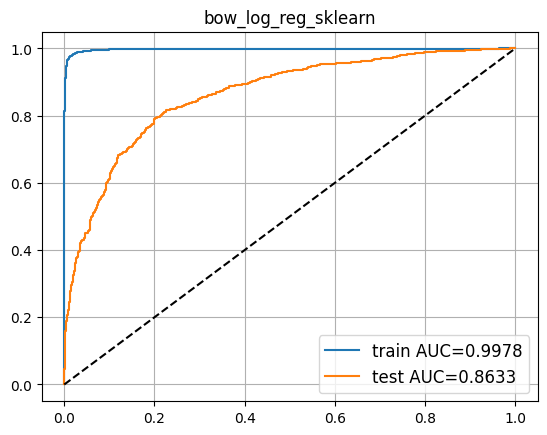

In [4]:
k = min(10000, len(set(" ".join(texts_train).split())))

counts = Counter(" ".join(texts_train).split())

bow_vocabulary = [key for key, val in counts.most_common(k)]


def text_to_bow(text):
    """convert text string to an array of token counts. Use bow_vocabulary."""
    sent_vec = np.zeros(len(bow_vocabulary))
    counts = Counter(text.split())
    for i, token in enumerate(bow_vocabulary):
        if token in counts:
            sent_vec[i] = counts[token]
    return np.array(sent_vec, "float32")


X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

k_max = len(set(" ".join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(
    X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in texts_train[5:10]])
)
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[65, bow_vocabulary.index("!")] == texts_train[65].split().count("!")


bow_model = LogisticRegression(max_iter=1500).fit(X_train_bow, y_train)

out_dict = visualize_and_save_results(
    bow_model, "bow_log_reg_sklearn", X_train_bow, X_test_bow, y_train, y_test, out_dict
)

In [5]:
len(set(" ".join(texts_train).split()))

11803

Результаты неплохие, но явно видно переобучение. Этот вывод можно сделать судя по значительному превосходству качества (AUC ROC) на train выборке относительно test. Более того, на обучающей выборке качество стремится к единице, в то время как на отложенной – значительно ниже, т.е. модель уловила множество зависимостей, свойственных лишь обучающей выборке. 

В данной задаче с переобучением мы разберемся в дальнейшем. Сейчас же реализуйте решение на основе логистической регрессии, но уже используя PyTorch.

In [6]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        # Один линейный слой, выход — 2 класса (логиты для каждого класса)
        self.fc = nn.Linear(input_dim, 2)

    def forward(self, x):
        return self.fc(x)

In [7]:
model = LogisticRegressionModel(input_dim=len(bow_vocabulary))  # Размер входа — размер словаря

In [8]:
loss_function = nn.BCEWithLogitsLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [9]:
X_train_bow_torch = torch.tensor(X_train_bow, dtype=torch.float32)
X_test_bow_torch = torch.tensor(X_test_bow, dtype=torch.float32)

y_train_torch = torch.tensor(y_train, dtype=torch.float32).view(-1, 2)  # Преобразуем в тензор с размерностью [N, 1]
y_test_torch = torch.tensor(y_test, dtype=torch.float32).view(-1, 2)

y_train_torch_one_hot = torch.nn.functional.one_hot(torch.tensor(y_train, dtype=torch.long), num_classes=2).float()
y_test_torch_one_hot = torch.nn.functional.one_hot(torch.tensor(y_test, dtype=torch.long), num_classes=2).float()

In [10]:
X_train_bow_torch.shape

torch.Size([5000, 10000])

In [11]:
y_train_torch.shape

torch.Size([2500, 2])

In [12]:
y_train_torch_one_hot.shape

torch.Size([5000, 2])

In [13]:
from sklearn.metrics import accuracy_score
import torch

def train_model(
    model,
    opt,
    X_train_torch,
    y_train_torch,
    X_val_torch,
    y_val_torch,
    n_iterations=500,
    batch_size=32,
    show_plots=True,
    eval_every=50
):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    local_train_loss_history = []
    local_train_acc_history = []
    for i in range(n_iterations):

        # sample batch_size random observations
        ix = np.random.randint(0, len(X_train_torch), batch_size)
        x_batch = X_train_torch[ix]
        y_batch = y_train_torch[ix]

        # predict log-probabilities or logits
        y_predicted = model(x_batch)

        # compute loss, just like before
        loss = loss_function(y_predicted, y_batch)

        # compute gradients
        opt.zero_grad()
        loss.backward()

        # Adam step
        opt.step()

        local_train_loss_history.append(loss.item())

        # Получаем индексы класса с максимальной вероятностью
        y_pred_class = y_predicted.argmax(dim=1)
        y_true_class = y_batch.argmax(dim=1)

        local_train_acc_history.append(
            accuracy_score(y_true_class.cpu().numpy(), y_pred_class.cpu().numpy())
        )

        if i % eval_every == 0:
            train_loss_history.append(np.mean(local_train_loss_history))
            train_acc_history.append(np.mean(local_train_acc_history))
            local_train_loss_history, local_train_acc_history = [], []

            # validation step
            predictions_val = model(X_val_torch)
            val_loss_history.append(loss_function(predictions_val, y_val_torch).to('cpu').detach().item())

            val_pred_class = predictions_val.argmax(dim=1)
            val_true_class = y_val_torch.argmax(dim=1)

            acc_score_val = accuracy_score(val_true_class.cpu().numpy(), val_pred_class.cpu().numpy())
            val_acc_history.append(acc_score_val)

            if show_plots:
                display.clear_output(wait=True)
                plot_train_process(train_loss_history, val_loss_history, train_acc_history, val_acc_history)
    return model


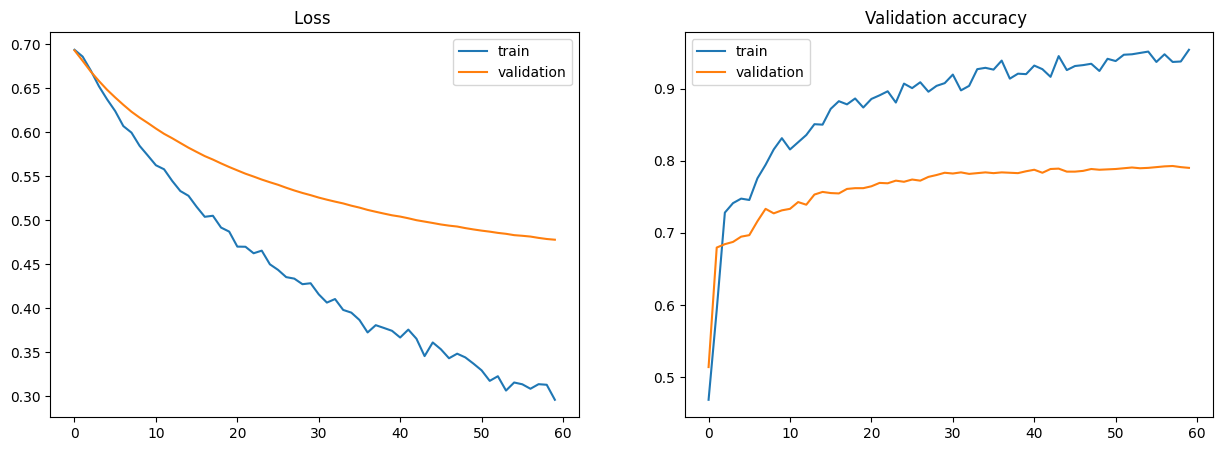

In [14]:
bow_nn_model = train_model(
    model,
    opt,
    X_train_bow_torch,
    y_train_torch_one_hot,
    X_test_bow_torch,
    y_test_torch_one_hot,
    n_iterations=3000,
)

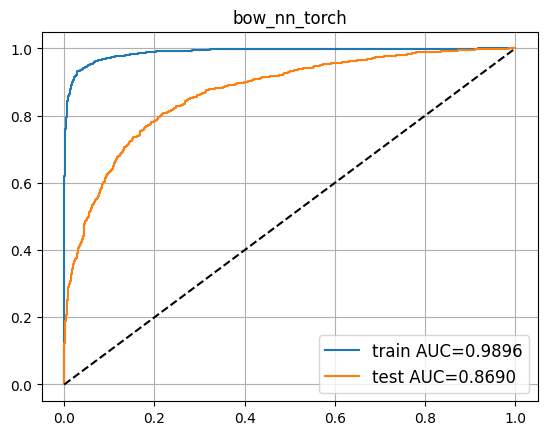

In [15]:
out_dict = visualize_and_save_results(
    bow_nn_model,
    "bow_nn_torch",
    X_train_bow_torch,
    X_test_bow_torch,
    y_train,
    y_test,
    out_dict,
)

assert (
    out_dict["bow_log_reg_sklearn_test"] - out_dict["bow_nn_torch_test"] < 0.01
), "AUC ROC on test data should be close to the sklearn implementation"


Повторим процедуру обучения выше, но для различных значений `k` – размера словаря. 

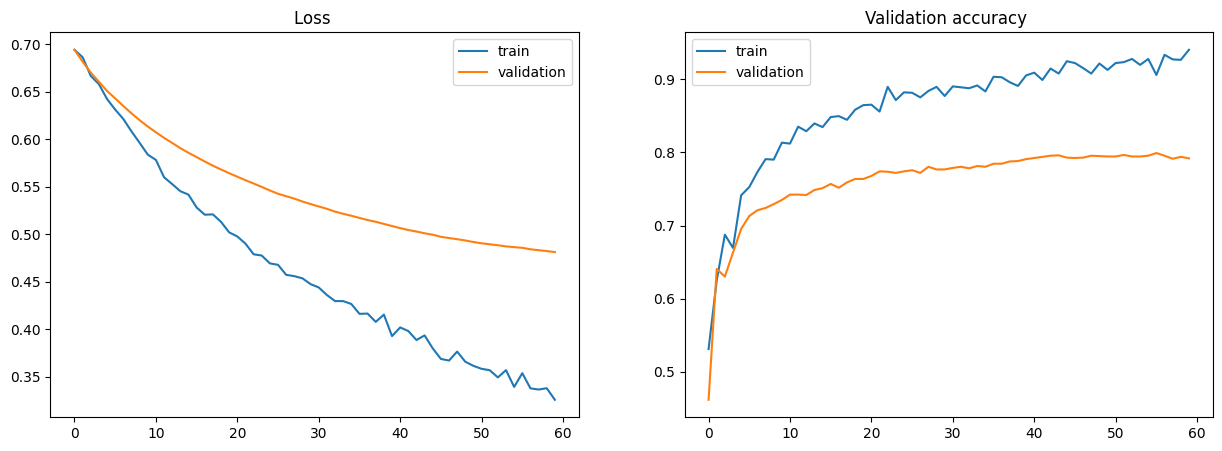

[0.6875937074273364, 0.8121051241042413, 0.8434897053659088, 0.8520670268366113, 0.8598381518476196, 0.8612396181140329, 0.8640806044244584, 0.8646394513297622, 0.8648916935127007]


In [16]:
vocab_sizes_list = np.arange(100, 5800, 700)
results = []

for k in vocab_sizes_list:
    # Формируем новый словарь для текущего k
    counts = Counter(" ".join(texts_train).split())
    bow_vocabulary = [key for key, val in counts.most_common(k)]

    # Преобразуем тексты в bag-of-words с новым словарём
    X_train_bow = np.stack(list(map(lambda text: text_to_bow(text), texts_train)))
    X_test_bow = np.stack(list(map(lambda text: text_to_bow(text), texts_test)))

    # Переобучаем модель с новым размером словаря
    model = LogisticRegressionModel(input_dim=len(bow_vocabulary))
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)

    # Тренируем модель
    model = train_model(
        model,
        opt,
        torch.tensor(X_train_bow, dtype=torch.float32),
        y_train_torch_one_hot,
        torch.tensor(X_test_bow, dtype=torch.float32),
        y_test_torch_one_hot,
        n_iterations=3000,
    )

    # Получаем вероятности на тестовом наборе
    with torch.no_grad():
        model.eval()
        y_pred = model(torch.tensor(X_test_bow, dtype=torch.float32))
        predicted_probas_on_test_for_k_sized_dict = torch.sigmoid(y_pred).cpu().numpy()[:, 1]  # Вероятности для положительного класса

    # Рассчитываем AUC-ROC для текущего размера словаря
    auc = roc_auc_score(y_test, predicted_probas_on_test_for_k_sized_dict)
    results.append(auc)

print(results)

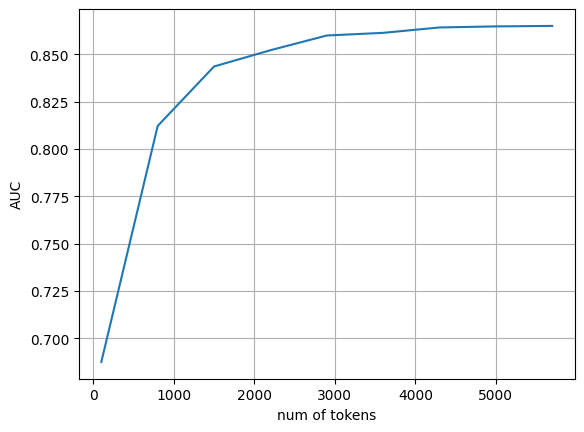

In [17]:
assert len(results) == len(vocab_sizes_list), "Check the code above"
assert min(results) >= 0.65, "Seems like the model is not trained well enough"
assert results[-1] > 0.84, "Best AUC ROC should not be lower than 0.84"

plt.plot(vocab_sizes_list, results)
plt.xlabel("num of tokens")
plt.ylabel("AUC")
plt.grid()

out_dict["bow_k_vary"] = results

# 2: Использование TF-iDF признаков.


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

max_vocab_size = 10000

vectorizer = TfidfVectorizer(max_features=max_vocab_size)

In [19]:
X_train_tfidf = vectorizer.fit_transform(texts_train).toarray()
X_test_tfidf = vectorizer.transform(texts_test).toarray()

print("X_train_tfidf:", X_train_tfidf.shape)
print("X_test_tfidf:", X_test_tfidf.shape)

X_train_tfidf: (5000, 10000)
X_test_tfidf: (1920, 10000)


In [20]:
X_train_tfidf_torch = torch.tensor(X_train_tfidf, dtype=torch.float32)
X_test_tfidf_torch = torch.tensor(X_test_tfidf, dtype=torch.float32)

y_train_torch = torch.nn.functional.one_hot(torch.tensor(y_train, dtype=torch.long), num_classes=2).float()
y_test_torch = torch.nn.functional.one_hot(torch.tensor(y_test, dtype=torch.long), num_classes=2).float()

In [21]:
print("X_train_tfidf:", X_train_tfidf_torch.shape)
print("X_test_tfidf:", X_test_tfidf_torch.shape)

print("y_train_tfidf:", y_train_torch.shape)
print("y_test_tfidf:", y_test_torch.shape)

X_train_tfidf: torch.Size([5000, 10000])
X_test_tfidf: torch.Size([1920, 10000])
y_train_tfidf: torch.Size([5000, 2])
y_test_tfidf: torch.Size([1920, 2])


In [22]:
model = LogisticRegressionModel(input_dim=X_train_tfidf.shape[1])

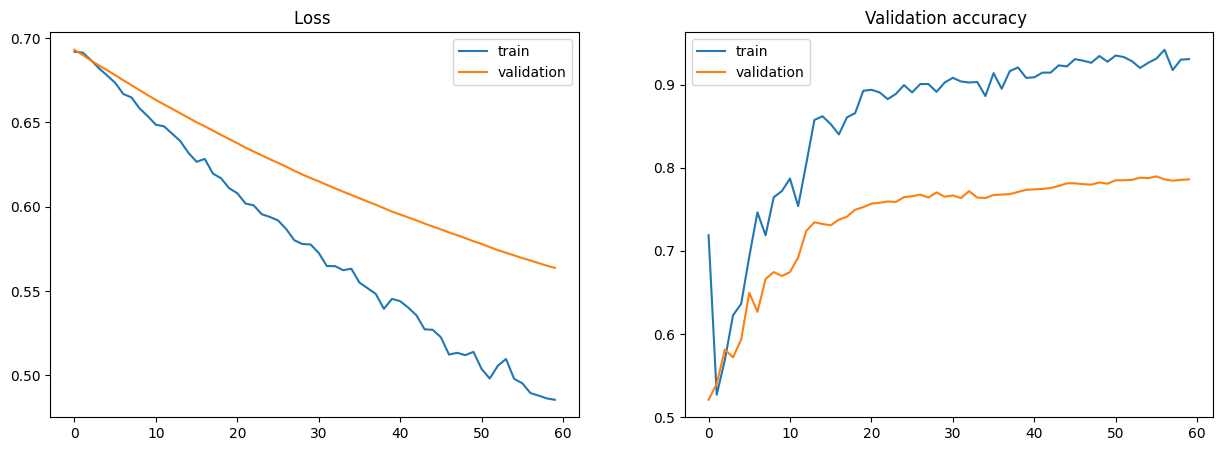

In [23]:
import torch.optim as optim

loss_function = nn.BCEWithLogitsLoss()
opt = optim.Adam(model.parameters(), lr=0.001)

model_tf_idf = train_model(model, opt, X_train_tfidf_torch, y_train_torch, X_test_tfidf_torch, y_test_torch, n_iterations=3000)

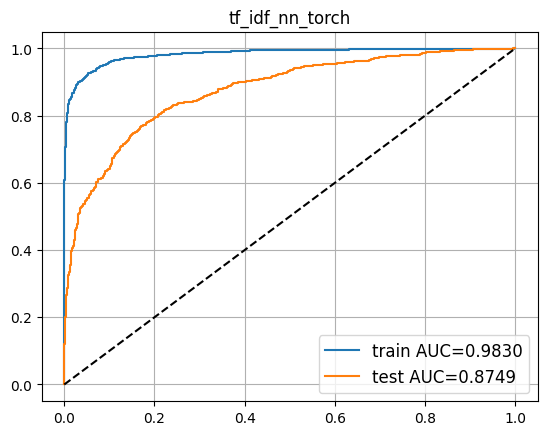

In [24]:
out_dict = visualize_and_save_results(
    model_tf_idf,
    "tf_idf_nn_torch",
    X_train_tfidf_torch,
    X_test_tfidf_torch,
    y_train,
    y_test,
    out_dict,
)

assert (
    out_dict["tf_idf_nn_torch_test"] >= out_dict["bow_nn_torch_test"]
), "AUC ROC on test data should be better or close to BoW for TF-iDF features"

In [25]:
# vocab_sizes_list = np.arange(100, 5800, 700)
# results = []

# for k in vocab_sizes_list:
#     # Формируем новый словарь для текущего k
#     counts = Counter(" ".join(texts_train).split())
#     bow_vocabulary = [key for key, val in counts.most_common(k)]

#     # Преобразуем тексты в bag-of-words с новым словарём
#     X_train_bow = np.stack(list(map(lambda text: text_to_bow(text), texts_train)))
#     X_test_bow = np.stack(list(map(lambda text: text_to_bow(text), texts_test)))

#     # Переобучаем модель с новым размером словаря
#     model = LogisticRegressionModel(input_dim=len(bow_vocabulary))
#     opt = torch.optim.Adam(model.parameters(), lr=1e-3)

#     # Тренируем модель
#     model = train_model(
#         model,
#         opt,
#         torch.tensor(X_train_bow, dtype=torch.float32),
#         y_train_torch_one_hot,
#         torch.tensor(X_test_bow, dtype=torch.float32),
#         y_test_torch_one_hot,
#         n_iterations=3000,
#     )

#     # Получаем вероятности на тестовом наборе
#     with torch.no_grad():
#         model.eval()
#         y_pred = model(torch.tensor(X_test_bow, dtype=torch.float32))
#         predicted_probas_on_test_for_k_sized_dict = torch.sigmoid(y_pred).cpu().numpy()[:, 1]  # Вероятности для положительного класса

#     # Рассчитываем AUC-ROC для текущего размера словаря
#     auc = roc_auc_score(y_test, predicted_probas_on_test_for_k_sized_dict)
#     results.append(auc)

# print(results)

In [26]:
vocab_sizes_list = np.arange(100, 5800, 700)
results = []

for k in vocab_sizes_list:

    vectorizer = TfidfVectorizer(max_features=k)
    X_train_tfidf = vectorizer.fit_transform(texts_train).toarray()
    X_test_tfidf = vectorizer.transform(texts_test).toarray()

    X_train_tfidf_torch = torch.tensor(X_train_tfidf, dtype=torch.float32)
    X_test_tfidf_torch = torch.tensor(X_test_tfidf, dtype=torch.float32)

    y_train_torch = torch.nn.functional.one_hot(torch.tensor(y_train, dtype=torch.long), num_classes=2).float()
    y_test_torch = torch.nn.functional.one_hot(torch.tensor(y_test, dtype=torch.long), num_classes=2).float()

    model = LogisticRegressionModel(input_dim=k)
    opt = optim.Adam(model.parameters(), lr=0.001)
    loss_function = nn.BCEWithLogitsLoss()

    train_model(
        model,
        opt,
        X_train_tfidf_torch,
        y_train_torch,
        X_test_tfidf_torch,
        y_test_torch,
        n_iterations=1000,
        show_plots=False
    )

    with torch.no_grad():
        y_test_pred = model(X_test_tfidf_torch).detach().numpy()
        predicted_probas_on_test_for_k_sized_dict = torch.sigmoid(torch.tensor(y_test_pred)).numpy()[:, 1]

    # Проверка, что предсказания существуют
    assert predicted_probas_on_test_for_k_sized_dict is not None

    auc = roc_auc_score(y_test, predicted_probas_on_test_for_k_sized_dict)
    results.append(auc)

    print(f"Размер словаря: {k}, AUC ROC: {auc:.4f}")

Размер словаря: 100, AUC ROC: 0.6836
Размер словаря: 800, AUC ROC: 0.8004
Размер словаря: 1500, AUC ROC: 0.8359
Размер словаря: 2200, AUC ROC: 0.8443
Размер словаря: 2900, AUC ROC: 0.8546
Размер словаря: 3600, AUC ROC: 0.8540
Размер словаря: 4300, AUC ROC: 0.8592
Размер словаря: 5000, AUC ROC: 0.8529
Размер словаря: 5700, AUC ROC: 0.8633


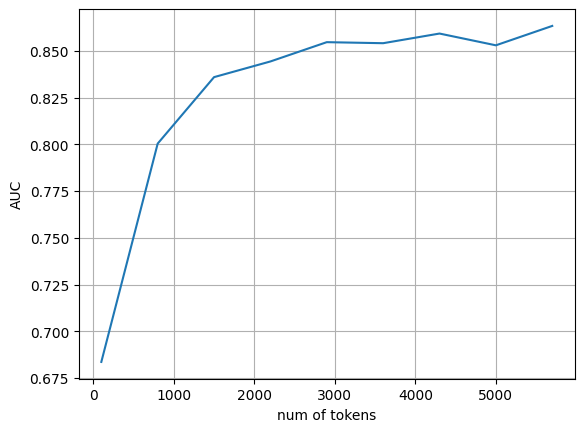

In [27]:
assert len(results) == len(vocab_sizes_list), "Check the code above"
assert min(results) >= 0.65, "Seems like the model is not trained well enough"
assert results[-1] > 0.85, "Best AUC ROC for TF-iDF should not be lower than 0.84"

plt.plot(vocab_sizes_list, results)
plt.xlabel("num of tokens")
plt.ylabel("AUC")
plt.grid()

out_dict["tf_idf_k_vary"] = results

# 3: Сравнение с Наивным Байесовским классификатором.


In [28]:
from sklearn.naive_bayes import MultinomialNB

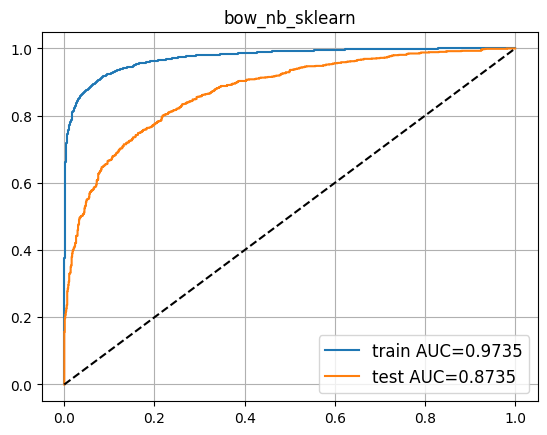

In [29]:
clf_nb_bow = MultinomialNB()
clf_nb_bow.fit(X_train_bow, y_train)

out_dict = visualize_and_save_results(clf_nb_bow, 'bow_nb_sklearn', X_train_bow, X_test_bow, y_train, y_test, out_dict)

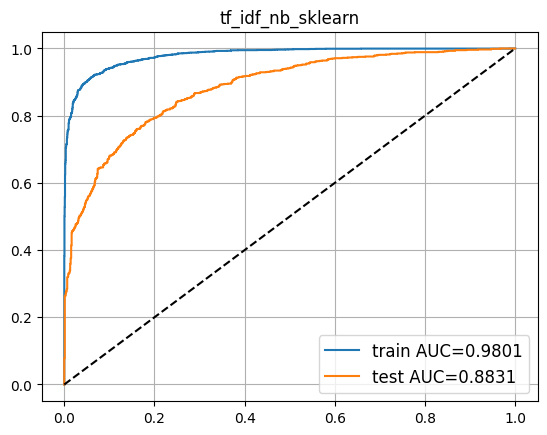

In [30]:
clf_nb_tfidf = MultinomialNB()
clf_nb_tfidf.fit(X_train_tfidf, y_train)

out_dict = visualize_and_save_results(clf_nb_tfidf, 'tf_idf_nb_sklearn', X_train_tfidf, X_test_tfidf, y_train, y_test, out_dict)

In [31]:
assert (
    out_dict["tf_idf_nb_sklearn_test"] > out_dict["bow_nb_sklearn_test"]
), " TF-iDF results should be better"
assert (
    out_dict["tf_idf_nb_sklearn_test"] > 0.86
), "TF-iDF Naive Bayes score should be above 0.86"

# 4: Использование предобученных эмбеддингов
### __Построение эмбеддингов с помощью word2vec__.


In [32]:
import gensim.downloader as api
gensim_embedding_model = api.load("glove-wiki-gigaword-100")

In [33]:
pip install transformers fasttext


In [34]:
from transformers import AutoTokenizer, AutoModel
import torch

In [35]:
# Загружаем предобученную модель BERT
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased")

def text_to_bert_embedding(text, model, tokenizer, max_length=128):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=max_length)
    with torch.no_grad():
        outputs = model(**inputs)
    # Используем [CLS] токен как представление текста
    return outputs.last_hidden_state[:, 0, :].squeeze(0).numpy()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [36]:
def text_to_average_embedding(text, gensim_embedding_model):
    tokens = text.split()
    embeddings = [gensim_embedding_model[token] for token in tokens if token in gensim_embedding_model]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(gensim_embedding_model.vector_size)

In [37]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [38]:
import fasttext.util

# Загружаем предобученную модель для английского языка
fasttext.util.download_model('en', if_exists='ignore')
ft = fasttext.load_model('cc.en.300.bin')


In [39]:
def synonym_replace_fasttext(text, model, prob=0.2):
    tokens = text.split()
    new_tokens = []
    for token in tokens:
        if random.random() < prob and token in model:
            # Ищем ближайшие слова
            similar_words = model.get_nearest_neighbors(token, k=5)
            if similar_words:
                synonym = similar_words[0][1]  # Берем наиболее близкое слово
                new_tokens.append(synonym)
            else:
                new_tokens.append(token)
        else:
            new_tokens.append(token)
    return " ".join(new_tokens)


In [40]:
def augment_text_v2(text):
    augmentations = [
        delete_random_words,
        lambda x: synonym_replace_fasttext(x, ft),
        shuffle_words,
        add_noise
    ]
    for aug in augmentations:
        if random.random() < 0.5:
            text = aug(text)
    return text


In [41]:
import random
from nltk.corpus import wordnet

# 1. Удаление случайных слов
def delete_random_words(text, prob=0.2):
    tokens = text.split()
    tokens = [word for word in tokens if random.random() > prob]
    return " ".join(tokens)

# 2. Синонимизация
def synonym_replace(text, prob=0.2):
    tokens = text.split()
    new_tokens = []
    for token in tokens:
        if random.random() < prob:
            synonyms = wordnet.synsets(token, pos=wordnet.VERB)
            if synonyms:
                synonym = synonyms[0].lemmas()[0].name()  # Берем первый синоним
                new_tokens.append(synonym)
            else:
                new_tokens.append(token)
        else:
            new_tokens.append(token)
    return " ".join(new_tokens)

# 3. Перемешивание слов
def shuffle_words(text, prob=0.2):
    tokens = text.split()
    if random.random() < prob:
        random.shuffle(tokens)
    return " ".join(tokens)

# 4. Добавление шума
def add_noise(text, noise_level=0.1):
    tokens = text.split()
    noise = ["word", "random", "noise", "text"]
    for _ in range(int(len(tokens) * noise_level)):
        tokens.insert(random.randint(0, len(tokens)), random.choice(noise))
    return " ".join(tokens)

# Применяем аугментации
def augment_text(text):
    augmentations = [delete_random_words, synonym_replace, shuffle_words, add_noise]
    for aug in augmentations:
        if random.random() < 0.5:  # С вероятностью 50% применяем каждую
            text = aug(text)
    return text


In [42]:
X_train_emb = [
    text_to_average_embedding(text, gensim_embedding_model) for text in texts_train
]
X_test_emb = [
    text_to_average_embedding(text, gensim_embedding_model) for text in texts_test
]

assert (
    len(X_train_emb[0]) == gensim_embedding_model.vector_size
), "Seems like the embedding shape is wrong"

In [43]:
X_train_emb_torch = torch.tensor(X_train_emb, dtype=torch.float32)
X_test_emb_torch = torch.tensor(X_test_emb, dtype=torch.float32)

mean = X_train_emb_torch.mean(dim=0)
std = X_train_emb_torch.std(dim=0)
X_train_emb_torch = (X_train_emb_torch - mean) / std
X_test_emb_torch = (X_test_emb_torch - mean) / std

y_train_torch = torch.tensor(y_train, dtype=torch.long)  # Длинные целые числа
y_test_torch = torch.tensor(y_test, dtype=torch.long)

<ipython-input-43-306b3d9df671>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  X_train_emb_torch = torch.tensor(X_train_emb, dtype=torch.float32)


In [46]:
def texts_to_bert_embeddings(texts, model, tokenizer, batch_size=16):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt")
        outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state[:, 0, :].detach().numpy()
        embeddings.extend(batch_embeddings)
    return embeddings


In [47]:
# Преобразуем тексты в эмбеддинги
X_train_bert = texts_to_bert_embeddings(texts_train, model, tokenizer)
X_test_bert = texts_to_bert_embeddings(texts_test, model, tokenizer)

# Преобразуем в тензоры
X_train_bert_torch = torch.tensor(X_train_bert, dtype=torch.float32)
X_test_bert_torch = torch.tensor(X_test_bert, dtype=torch.float32)

In [ ]:
texts_train_augmented = [augment_text_v2(text) for text in texts_train]
X_train_aug = [
    text_to_bert_embedding(text, model, tokenizer) for text in texts_train_augmented
]

In [1]:
X_train_combined = torch.cat(
    [torch.tensor(X_train_emb, dtype=torch.float32), torch.tensor(X_train_aug, dtype=torch.float32)], dim=0
)
y_train_combined = torch.cat([y_train_torch, y_train_torch], dim=0)


NameError: name 'torch' is not defined

In [ ]:
y_train_torch.shape

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x



In [ ]:
def train_model(model, optimizer, scheduler, X_train, y_train, X_test, y_test, n_iterations=3000):
    model.train()
    best_test_auc = 0.0
    for epoch in range(n_iterations):
        optimizer.zero_grad()
        predictions = model(X_train)
        loss = loss_function(predictions, y_train)
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0 or best_test_auc > 0.86:
            model.eval()
            with torch.no_grad():
                # Softmax для вероятностей
                train_pred = torch.softmax(model(X_train), dim=1)[:, 1]
                test_pred = torch.softmax(model(X_test), dim=1)[:, 1]

                train_auc = roc_auc_score(y_train.cpu().numpy(), train_pred.cpu().numpy())
                test_auc = roc_auc_score(y_test.cpu().numpy(), test_pred.cpu().numpy())

                if test_auc > best_test_auc:
                    best_test_auc = test_auc

                print(
                    f"Epoch {epoch}, Loss: {loss.item():.4f}, "
                    f"Train AUC: {train_auc:.4f}, Test AUC: {test_auc:.4f}"
                )

                # # Остановка обучения, если достигли желаемого результата
                # if test_auc > 0.86:
                #     print("Target AUC reached, stopping early!")
                #     return model


            scheduler.step(test_auc)

            model.train()

    return model


In [ ]:
model = SimpleNN(input_dim=gensim_embedding_model.vector_size)

In [101]:
loss_function = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)

model = train_model(model, opt, scheduler, X_train_combined, y_train_combined, X_test_emb_torch, y_test_torch, n_iterations=3000)


Epoch 0, Loss: 0.6928, Train AUC: 0.5773, Test AUC: 0.5549
Epoch 500, Loss: 0.5065, Train AUC: 0.8444, Test AUC: 0.8304
Epoch 1000, Loss: 0.4957, Train AUC: 0.8507, Test AUC: 0.8353
Epoch 1500, Loss: 0.4890, Train AUC: 0.8544, Test AUC: 0.8370
Epoch 2000, Loss: 0.4862, Train AUC: 0.8564, Test AUC: 0.8374
Epoch 2500, Loss: 0.4834, Train AUC: 0.8572, Test AUC: 0.8374


AssertionError: AUC ROC on test data should be better than 0.86

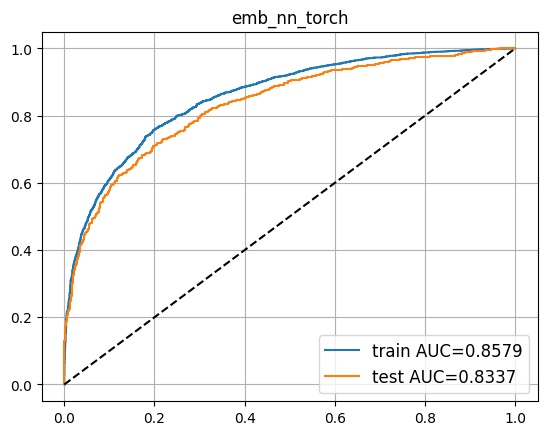

In [102]:
out_dict = visualize_and_save_results(
    model,
    "emb_nn_torch",
    X_train_emb_torch,
    X_test_emb_torch,
    y_train,
    y_test,
    out_dict,
)
assert (
    out_dict["emb_nn_torch_test"] > 0.87
), "AUC ROC on test data should be better than 0.86"
assert (
    out_dict["emb_nn_torch_train"] - out_dict["emb_nn_torch_test"] < 0.1
), "AUC ROC on test and train data should not be different more than by 0.1"
